In this code, we will import the samples dictionary from the calibration procedure and create
1. A fit to the data
2. A corner plot

In [52]:
# Preamble
import corner
import pandas as pd
import json
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt

from covid19model.models import models
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_contact_matrix_function
from covid19model.models.utils import initial_state
# from covid19model.optimization.run_optimization import checkplots, calculate_R0
# from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
# from covid19model.optimization import pso, objective_fcns
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot, plot_fit, plot_calibration_fit
from covid19model.visualization.utils import moving_avg
from covid19model.optimization.utils import perturbate_PSO, run_MCMC
from covid19model.optimization.utils import samples_dict_to_emcee_chain # used for corner plots
import random
import datetime

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visual output

In [76]:
##################
### USER INPUT ###
##################

# Simulation properties
agg = 'arr'
job = 'FULL'
maxiter = 100
number = 1000
init_number = 9
init = 'data'
date = '2021-05-27'

###################

# Automated name
json_name = f"{agg}_WAVE1-{job}_job-{job}_{str(maxiter)}xPSO_{str(number)}xMCMC_{agg}_{str(init_number)}-index-in-{init}_{date}.json"
json_loc = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict = json.load(open(f'{json_loc}/{json_name}'))
parNames_mcmc = ['beta_R', 'beta_U', 'beta_M']
labels = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$']
if job == 'FULL':
    parNames_mcmc += ['l', 'prev_home', 'prev_schools', 'prev_work', 'prev_rest']
    labels += ['$l$', '$\Omega_{home}$', '$\Omega_{schools}$', '$\Omega_{work}$', '$\Omega_{rest}$']
nwalkers=samples_dict[f'n_chains_{job}']
discard=0
thin=50
samples,flat_samples = samples_dict_to_emcee_chain(samples_dict, parNames_mcmc, nwalkers, discard=discard, thin=thin)

# len(samples_dict['beta_R'])/50
# samples_dict['warmup']

samples_dict.keys()

dict_keys(['beta_R', 'beta_U', 'beta_M', 'l', 'prev_home', 'prev_schools', 'prev_work', 'prev_rest', 'warmup', 'start_date_FULL', 'end_date_FULL', 'n_chains_FULL'])

## Traceplot

See `results/calibrations/COVID19_SEIRD/{agg}/traceplots`

## Autocorrelation

See `results/calibrations/COVID19_SEIRD/{agg}/autocorrelation`

## Corner plot

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


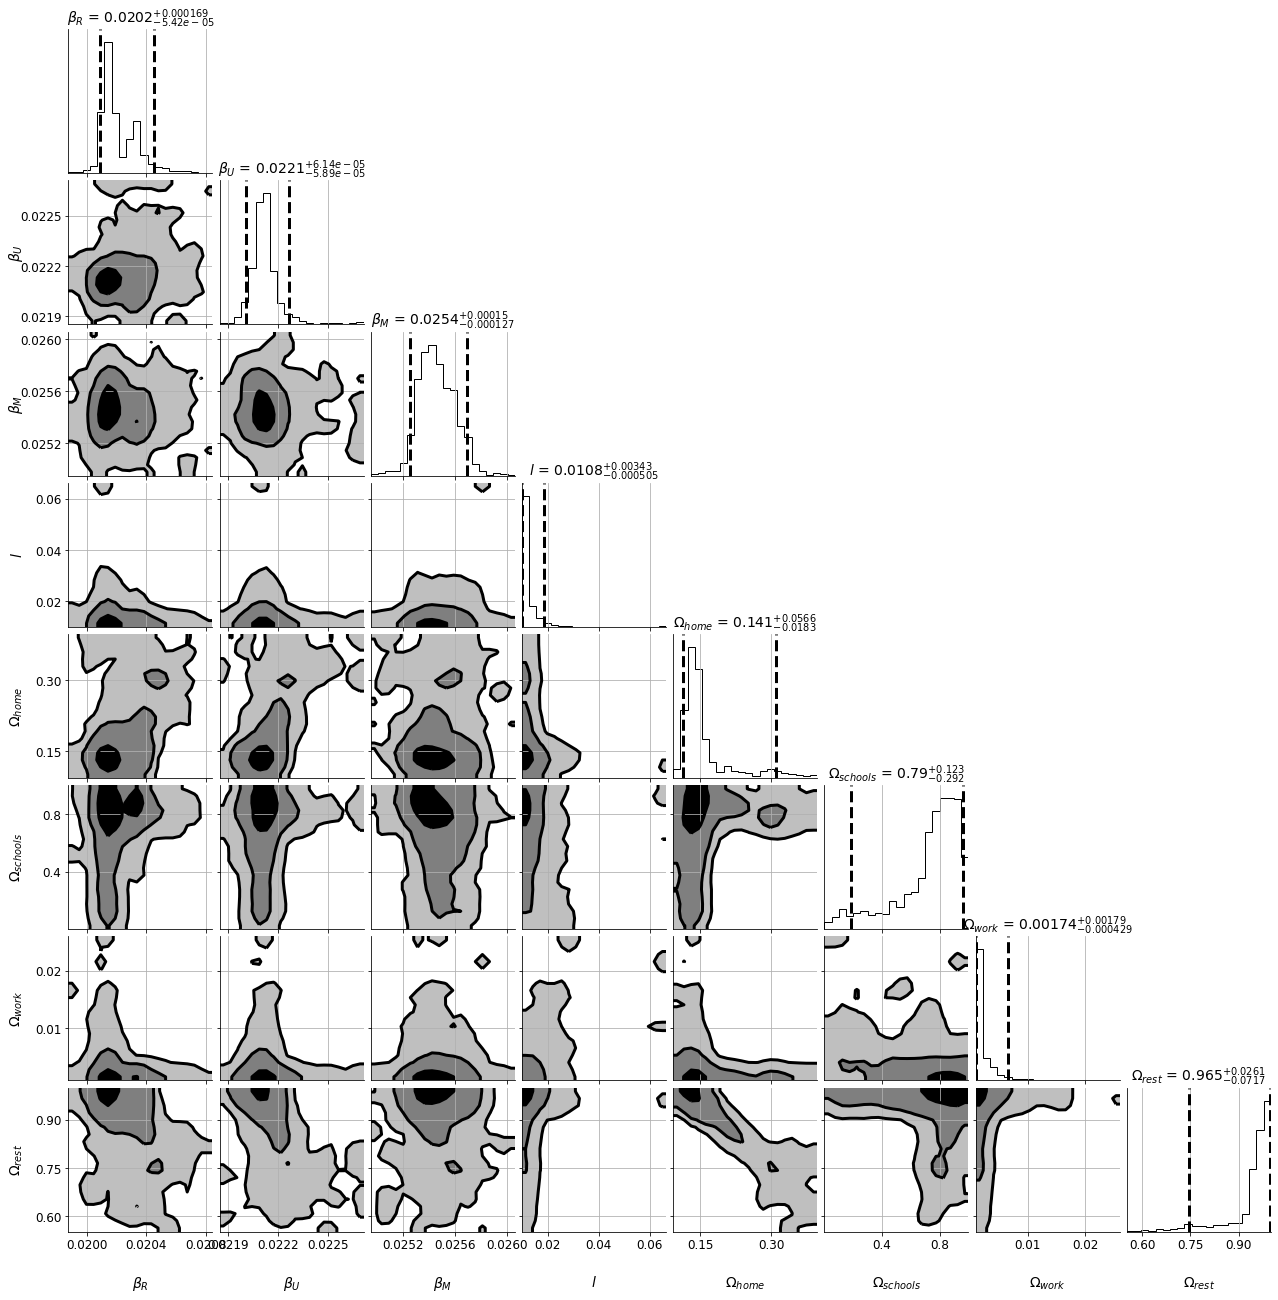

In [77]:
CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=14),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.05, 0.95],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3"
)
    # range=[(0,0.12),(0,5.2),(0,15)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples
fig = corner.corner(flat_samples, labels=labels, **CORNER_KWARGS)

for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12, rotation=0)

# Save figure
fig.show()
savename = f'../../results/calibrations/COVID19_SEIRD/arr/cornerplots/{json_name[:-5]}_CORNER.png'
fig.savefig(savename, dpi=400, bbox_inches='tight')
# plt.close()

## Fit to data

### Load model data

In [78]:
# Load and format mobility dataframe
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Total population and contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)

# Sciensano data: *hospitalisations* (H_in) moving average at spatial level {agg}. Column per NIS code
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN')

### Time-dependant data

In [79]:
# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# Social behaviour update function from class __call__ (contact_matrix_4prev) and function wrapper to get the right signature
policies_wave1_4prev = make_contact_matrix_function(df_google, Nc_all).policies_wave1_4prev

### Load model

In [88]:
# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, VOC=False)
# Add the time-dependant parameter function arguments
params.update({'l' : 5, # formality
               'tau' : 0.1, # 5, # formality
               'prev_home' : 0.5, # formality
               'prev_schools': 0.5, # formality
               'prev_work': 0.5, # formality
               'prev_rest': 0.5 # formality
              })
# Add parameters for the daily update of proximus mobility
# mobility defaults to average mobility of 2020 if no data is available
params.update({'default_mobility' : None})

# --------------------
# Model initialisation
# --------------------

# Initial states, depending on args parser. Age is hard-coded
age=40
initE = initial_state(dist=init, agg=agg, age=age, number=init_number) # 40-somethings dropped in Brussels (arrival by plane)
initial_states = {'S': initN, 'E': initE/2}

# Initiate model with initial states, defined parameters, and proper time dependent functions
model = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : policies_wave1_4prev, 'place' : mobility_wrapper_function}, spatial=agg)


In [81]:
if job == 'R0':
    def draw_fcn(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        return param_dict
elif job == 'FULL':
    def draw_fcn(param_dict,samples_dict):
        # pick one random value from the dictionary
        idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
        # take out the other parameters that belong to the same iteration
        param_dict['beta_U'] = samples_dict['beta_U'][idx]
        param_dict['beta_M'] = samples_dict['beta_M'][idx]
        param_dict['l'] = samples_dict['l'][idx]
        param_dict['prev_home'] = samples_dict['prev_home'][idx]
        param_dict['prev_schools'] = samples_dict['prev_schools'][idx]
        param_dict['prev_work'] = samples_dict['prev_work'][idx]
        param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
        return param_dict

In [82]:
start_sim = samples_dict[f'start_date_{job}']
end_sim = samples_dict[f'end_date_{job}']
warmup = samples_dict['warmup']
n_samples = 100
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict, verbose=True)

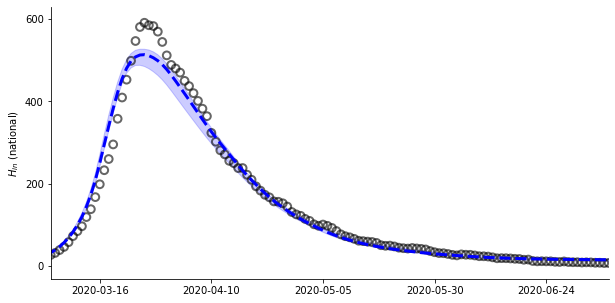

In [83]:
savename = f'../../results/calibrations/COVID19_SEIRD/arr/others/{json_name[:-5]}_FIT.png'
# savename=None
NIS=None

ax = plot_calibration_fit(out, df_sciensano, 'H_in', start_sim, end_sim, NIS=NIS, savename=savename)
ax.grid(False)

# Complete calibration: `job=FULL`

In [39]:
json_name = "arr_WAVE1-FULL_test-run_2021-05-19.json"
json_loc = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict = json.load(open(f'{json_loc}/{json_name}'))
parNames_mcmc = ['beta_R', 'beta_U', 'beta_M', 'l', 'prev_home', 'prev_schools', 'prev_work', 'prev_rest']
labels = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$', '$l$', '$\Omega_{home}$', '$\Omega_{schools}$', '$\Omega_{work}$', '$\Omega_{rest}$']
nwalkers=samples_dict['n_chains_FULL']
discard=0
thin=1
samples,flat_samples = samples_dict_to_emcee_chain(samples_dict, parNames_mcmc, nwalkers, discard=discard, thin=thin)

## Traceplot

See `results/calibrations/COVID19_SEIRD/arr/traceplots`

## Autocorrelation

See `results/calibrations/COVID19_SEIRD/arr/autocorrelation`

## Corner plot

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


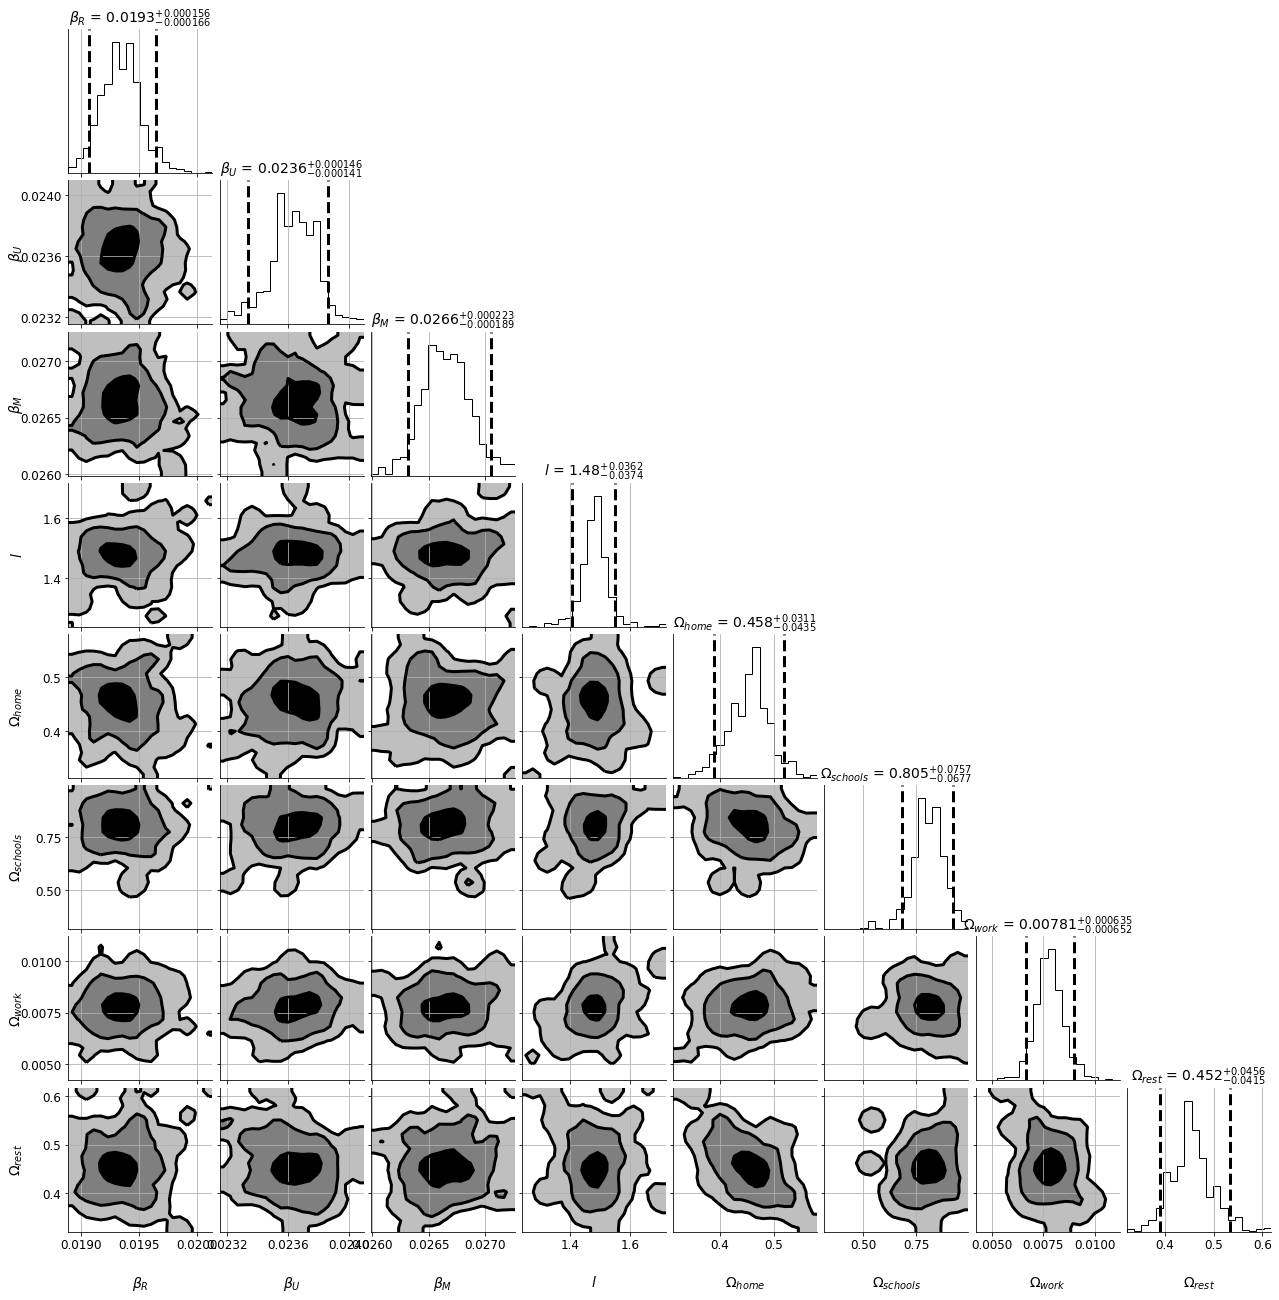

In [40]:
CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=14),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.05, 0.95],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3"
)
    # range=[(0,0.12),(0,5.2),(0,15)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples
fig = corner.corner(flat_samples, labels=labels, **CORNER_KWARGS)

for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12, rotation=0)

# Save figure
fig.show()
# fig.savefig(fig_path+'cornerplots/'+spatial_unit+'_CORNER_BETAs_comp_postlockdown_'+run_date+'.pdf', dpi=400, bbox_inches='tight')
# plt.close()

## Fit to data

### Load model data

In [41]:
# Load and format mobility dataframe
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Total population and contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)

# Sciensano data: *hospitalisations* (H_in) moving average at spatial level {agg}. Column per NIS code
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN')

### Time-dependant function

In [42]:
# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# Social behaviour update function from class __call__ (contact_matrix_4prev) and function wrapper to get the right signature
policies_wave1_4prev = make_contact_matrix_function(df_google, Nc_all).policies_wave1_4prev

### Load model

In [43]:
# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, VOC=False)
# Add the time-dependant parameter function arguments
params.update({'l' : 5, # will be varied over in the PSO/MCMC
               'tau' : 0.1, # 5, # Tijs's tip: tau has little to no influence. Fix it.
               'prev_home' : 0.5, # will be varied over in the PSO/MCMC
               'prev_schools': 0.5, # will be varied over in the PSO/MCMC
               'prev_work': 0.5, # will be varied over in the PSO/MCMC
               'prev_rest': 0.5 # will be varied over in the PSO/MCMC
              })
# Add parameters for the daily update of proximus mobility
# mobility defaults to average mobility of 2020 if no data is available
params.update({'default_mobility' : None})

# --------------------
# Model initialisation
# --------------------

# Initial states, depending on args parser. Age is hard-coded
age=40
initE = initial_state(dist=init, agg=agg, age=age, number=init_number) # 40-somethings dropped in Brussels (arrival by plane)
initial_states = {'S': initN, 'E': initE}

# Initiate model with initial states, defined parameters, and proper time dependent functions
model = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : policies_wave1_4prev, 'place' : mobility_wrapper_function}, spatial=agg)

In [44]:
def draw_fcn(param_dict,samples_dict):
    # pick one random value from the dictionary
    idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
    # take out the other parameters that belong to the same iteration
    param_dict['beta_U'] = samples_dict['beta_U'][idx]
    param_dict['beta_M'] = samples_dict['beta_M'][idx]
    param_dict['l'] = samples_dict['l'][idx]
    param_dict['prev_home'] = samples_dict['prev_home'][idx]
    param_dict['prev_schools'] = samples_dict['prev_schools'][idx]
    param_dict['prev_work'] = samples_dict['prev_work'][idx]
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
    return param_dict

In [46]:
start_sim = samples_dict['start_date_FULL']
end_sim = samples_dict['end_date_FULL']
warmup = samples_dict['warmup']
n_samples = 100
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict)

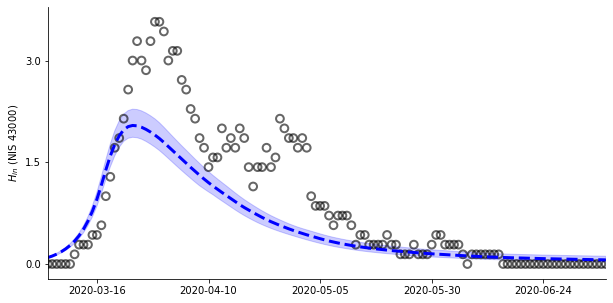

In [53]:
savename = '../../results/calibrations/COVID19_SEIRD/arr/others/...'
NIS=43000
ax = plot_calibration_fit(out, df_sciensano, 'H_in', start_sim, end_sim, NIS=NIS) #, savename=savename)
ax.grid(False)